In [8]:
#Import libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from utils import preprocess_text

import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt


import numpy as np
np.random.seed(42)

In [9]:
data = pd.read_csv('data\Phishing_Email.csv')
data.drop("Unnamed: 0", axis=1, inplace=True)

# Preprocess text

In [10]:
sample_size = 1000
label_encoder = LabelEncoder()

X = data['Email Text'].iloc[:sample_size].apply(preprocess_text)
y = data['Email Type'].iloc[:sample_size]
y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choose the best model

We are gonna try the best combination of model and Encoder, then we will choose the best one.

In [11]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier


models = {
    'SVC': {'model': SVC(random_state=42)},
    'KNN': {'model': KNeighborsClassifier()},
    'XGBoost': {'model': XGBClassifier(random_state=42)},
    'LogisticRegression': {'model': LogisticRegression()},
    'RandomForest': {'model': RandomForestClassifier(random_state=42)},
    'NaiveBayes': {'model': MultinomialNB()},
    'GradientBoosting': {'model': GradientBoostingClassifier(random_state=42)},
    'DecisionTree': {'model': DecisionTreeClassifier(random_state=42)},
    'SVM_Poly': {'model': SVC(kernel='poly',random_state=42)},
    'KNN_Weighted': {'model': KNeighborsClassifier(weights='distance')},
}

vectorizers = {
    'BoW': {'vectorizer': CountVectorizer()},
    'TF-IDF': {'vectorizer': TfidfVectorizer()},
    # 'Word2Vec': {'vectorizer': None}
}

Best model: KNN
Best vectorizer: TF-IDF
accuracy_score: 0.935

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        78
           1       0.97      0.93      0.95       122

    accuracy                           0.94       200
   macro avg       0.93      0.94      0.93       200
weighted avg       0.94      0.94      0.94       200



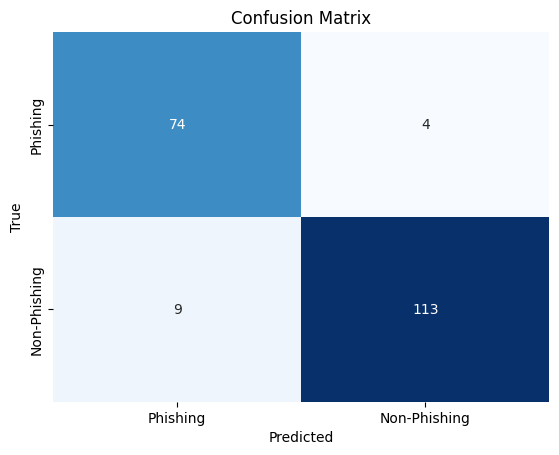

In [12]:
best_model = None
best_score = 0
best_vectorizer = None

for model_name, model_data in models.items():
    for vectorizer_name, vectorizer_data in vectorizers.items():
        vectorizer = vectorizer_data['vectorizer']
        model = model_data['model']
        
        pipeline = Pipeline([
            ('Vectorize', vectorizer),
            ('Model', model)
        ])
        
        pipeline.fit(X_train, y_train)
        
        if pipeline.score(X_test, y_test) > best_score:
            best_score = pipeline.score(X_test, y_test)
            best_model = model_name
            best_vectorizer = vectorizer_name
            best_pipeline = pipeline

print(f'Best model: {best_model}')
print(f'Best vectorizer: {best_vectorizer}')

best_pipeline.fit(X_train, y_train)

print(f'accuracy_score: {accuracy_score(y_test, best_pipeline.predict(X_test))}\n')
print(f'Classification Report:\n{classification_report(y_test, best_pipeline.predict(X_test))}')
sns.heatmap(confusion_matrix(y_test, best_pipeline.predict(X_test)), annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Phishing","Non-Phishing"], yticklabels=["Phishing","Non-Phishing"])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Based on the confusion matrix and the classification report, it is evident that the model is performing well. To further enhance the model's performance, we will explore hyperparameter tuning. We will utilize GridSearchCV to identify the optimal hyperparameters for the model

# Optimisation by tuning the model hyperparameters

In [13]:
param_grid = {
    'n_neighbors': [3, 5, 11, 19, 25],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

best_vectorizer_ = vectorizers[best_vectorizer]['vectorizer']
model_GRCV = models[best_model]['model']

X_train_vectorized = best_vectorizer_.fit_transform(X_train)

grid_search = GridSearchCV(estimator=model_GRCV, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train_vectorized, y_train)  

best_params_GRCV = grid_search.best_params_
best_model_GRCV = grid_search.best_estimator_
best_score_GRCV = grid_search.best_score_

print(f'Best params: {best_params_GRCV} \nBest score: {best_score_GRCV}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'} 
Best score: 0.925


accuracy_score: 0.935

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        78
           1       0.97      0.93      0.95       122

    accuracy                           0.94       200
   macro avg       0.93      0.94      0.93       200
weighted avg       0.94      0.94      0.94       200



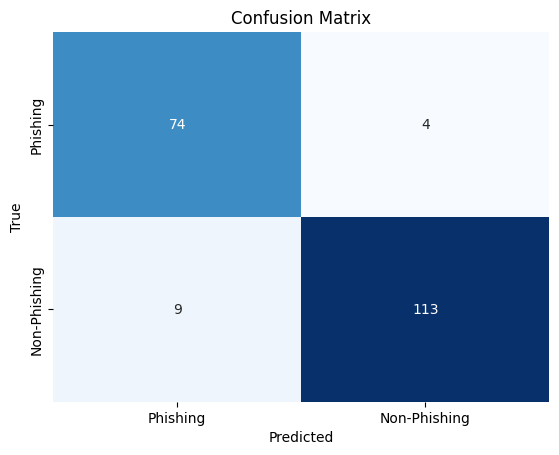

In [14]:
pipeline_best_hyperparameter = Pipeline([
    ('Vectorize', best_vectorizer_),
    ('Model', best_model_GRCV)
])

pipeline_best_hyperparameter.fit(X_train, y_train)

print(f'accuracy_score: {accuracy_score(y_test, pipeline_best_hyperparameter.predict(X_test))}\n')
print(f'Classification Report:\n{classification_report(y_test, pipeline_best_hyperparameter.predict(X_test))}')
sns.heatmap(confusion_matrix(y_test, pipeline_best_hyperparameter.predict(X_test)), annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Phishing","Non-Phishing"], yticklabels=["Phishing","Non-Phishing"])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

We will examine the F1 score for each class in the classification report to evaluate the model's performance, as it serves as a relevant indicator. The F1-score represents the harmonic mean of precision and recall. In this case, the F1-score is close to 1, indicating that our model is performing well.

Now that our model has the optimal hyperparameters, we will visualize the learning curve to determine if it is overfitting or underfitting. This analysis will help us assess whether it is beneficial to either expand our dataset with more data or remove some existing data.

# Verification of overfitting and implement an early stopper

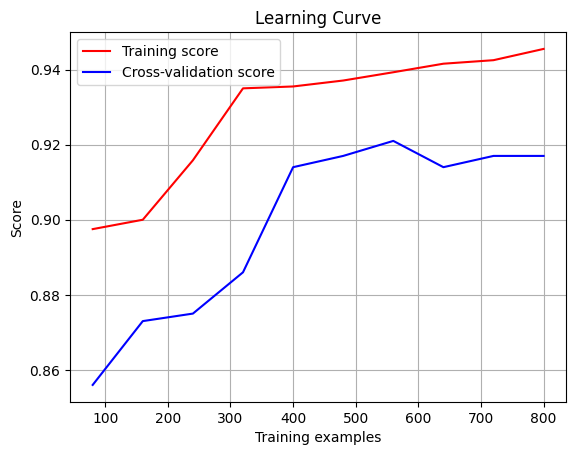

In [15]:
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, train_sizes=np.linspace(0.1, 1, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, color="b", label="Cross-validation score")

    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.legend()
    plt.show()


plot_learning_curve(pipeline_best_hyperparameter, X, y)

We can observe that the Cross-validation score (Testing score) increases as the number of training examples grows. This suggests that our model is not overfitting the training data. While it's possible to further increase the number of training examples to potentially improve the score, it's not necessary and would significantly extend the training time. This also serves as a valuable point of consideration to assess whether Deep Learning would be substantially superior in this case or not.

With this information, there is no immediate need to implement an early stop mechanism in our model, as it still has the potential to achieve better accuracy with the dataset we have used for training and testing.